In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm

In [5]:
stocks_names = ['msft']
stocks_path = [f'../data/Stocks/{name}.us.txt' for name in stocks_names]

def load_stock_data(stock_path):
    stock = pd.read_csv(stock_path)
    stock['Date'] = pd.to_datetime(stock['Date'], format='%Y-%m-%d')
    stock = stock.set_index('Date')
    return stock

stocks = [load_stock_data(path) for path in stocks_path]

# Convert the stocks to a single dataframe with the stock names as columns and the date as the index
stocks = pd.concat(stocks, axis=1, keys=stocks_names)

# Drop the NaN values
stocks = stocks.dropna()

# Filter the data to only be from 2010 to today
stocks = stocks.loc['2010-01-01':]

# Change the index to be a number instead of a date
stocks = stocks.reset_index()

# Remove the date column and the OpenInt column
stocks = stocks.drop('Date', axis=1)
stocks = stocks.drop('OpenInt', axis=1, level=1)

stocks.head()

/tmp/ipykernel_120706/4174181148.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  stocks = stocks.drop('Date', axis=1)


msft                                  
     Open    High     Low   Close    Volume
0  25.703  26.080  25.650  25.954  45790852
1  25.886  26.080  25.694  25.963  59323680
2  25.896  26.063  25.595  25.803  69369170
3  25.669  25.745  25.317  25.535  60292577
4  25.384  25.896  25.359  25.712  61051405

In [6]:
def generate_x_y(stks, window_size):
    x = []
    y = []
    for i in tqdm(range(len(stks) - window_size)):
        input_data = [[stks.iloc[i + j][s]['Close'] for s in stocks_names] for j in range(window_size)]
        x.append(input_data)
        output_data = [stks.iloc[i + window_size][s]['Close'] for s in stocks_names]
        y.append(output_data)
    return np.array(x), np.array(y)

In [7]:
window_size = 10
x,y = generate_x_y(stocks, window_size)

  0%|          | 8/1970 [00:00<00:24, 79.37it/s]

100%|██████████| 1970/1970 [00:04<00:00, 476.68it/s]


In [8]:
# Shuffle the data
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

n = len(x)

# create the training, validation, and test sets from x and y
train_stocks = x[:int(n*0.7)]
val_stocks = x[int(n*0.7):int(n*0.85)]
test_stocks = x[int(n*0.85):]

train_labels = y[:int(n*0.7)]
val_labels = y[int(n*0.7):int(n*0.85)]
test_labels = y[int(n*0.85):]


# Normalize the data
#train_mean = train_stocks.mean()
#train_std = train_stocks.std()

#train_stocks = (train_stocks - train_mean) / train_std
#val_stocks = (val_stocks - train_mean) / train_std
#test_stocks = (test_stocks - train_mean) / train_std

In [10]:
print("train => ", train_stocks.shape, train_labels.shape)
print("val => ", val_stocks.shape, val_labels.shape)
print("test => ", test_stocks.shape, test_labels.shape)

train =>  (1379, 10, 1) (1379, 1)
val =>  (295, 10, 1) (295, 1)
test =>  (296, 10, 1) (296, 1)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((window_size, len(stocks_names))))
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(stocks_names), activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [14]:
# Train the model
history = model.fit(train_stocks, train_labels, epochs=100, validation_data=(val_stocks, val_labels), callbacks=[cp])

Epoch 1/100
41/44 [==========================>...] - ETA: 0s - loss: 1659.9755 - root_mean_squared_error: 40.7428INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 5s 78ms/step - loss: 1661.5281 - root_mean_squared_error: 40.7618 - val_loss: 1670.2285 - val_root_mean_squared_error: 40.8684
Epoch 2/100
42/44 [===========================>..] - ETA: 0s - loss: 1634.8737 - root_mean_squared_error: 40.4336INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 83ms/step - loss: 1636.4884 - root_mean_squared_error: 40.4535 - val_loss: 1650.0875 - val_root_mean_squared_error: 40.6213
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 1619.5421 - root_mean_squared_error: 40.2435INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 65ms/step - loss: 1619.5421 - root_mean_squared_error: 40.2435 - val_loss: 1633.5717 - val_root_mean_squared_error: 40.4175
Epoch 4/100
41/44 [==========================>...] - ETA: 0s - loss: 1612.3153 - root_mean_squared_error: 40.1536INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 57ms/step - loss: 1602.9681 - root_mean_squared_error: 40.0371 - val_loss: 1615.9861 - val_root_mean_squared_error: 40.1993
Epoch 5/100
43/44 [============================>.] - ETA: 0s - loss: 1581.5916 - root_mean_squared_error: 39.7692INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 69ms/step - loss: 1580.2417 - root_mean_squared_error: 39.7523 - val_loss: 1585.4862 - val_root_mean_squared_error: 39.8182
Epoch 6/100
41/44 [==========================>...] - ETA: 0s - loss: 1550.8306 - root_mean_squared_error: 39.3806INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 67ms/step - loss: 1545.2507 - root_mean_squared_error: 39.3097 - val_loss: 1546.4875 - val_root_mean_squared_error: 39.3254
Epoch 7/100
37/44 [========================>.....] - ETA: 0s - loss: 1522.7087 - root_mean_squared_error: 39.0219INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 64ms/step - loss: 1506.2555 - root_mean_squared_error: 38.8105 - val_loss: 1506.2490 - val_root_mean_squared_error: 38.8104
Epoch 8/100
34/44 [======================>.......] - ETA: 0s - loss: 1474.3922 - root_mean_squared_error: 38.3978INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 70ms/step - loss: 1465.2410 - root_mean_squared_error: 38.2785 - val_loss: 1462.8373 - val_root_mean_squared_error: 38.2471
Epoch 9/100
43/44 [============================>.] - ETA: 0s - loss: 1417.7747 - root_mean_squared_error: 37.6533INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 80ms/step - loss: 1419.0435 - root_mean_squared_error: 37.6702 - val_loss: 1411.2002 - val_root_mean_squared_error: 37.5659
Epoch 10/100
43/44 [============================>.] - ETA: 0s - loss: 1362.4363 - root_mean_squared_error: 36.9112INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 1362.8749 - root_mean_squared_error: 36.9171 - val_loss: 1349.3687 - val_root_mean_squared_error: 36.7338
Epoch 11/100
39/44 [=========================>....] - ETA: 0s - loss: 1307.5034 - root_mean_squared_error: 36.1594INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 5s 122ms/step - loss: 1301.3593 - root_mean_squared_error: 36.0744 - val_loss: 1287.3071 - val_root_mean_squared_error: 35.8791
Epoch 12/100
39/44 [=========================>....] - ETA: 0s - loss: 1249.6721 - root_mean_squared_error: 35.3507INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 79ms/step - loss: 1243.5416 - root_mean_squared_error: 35.2639 - val_loss: 1230.9916 - val_root_mean_squared_error: 35.0855
Epoch 13/100
38/44 [========================>.....] - ETA: 0s - loss: 1190.5524 - root_mean_squared_error: 34.5044INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 1190.2786 - root_mean_squared_error: 34.5004 - val_loss: 1180.7654 - val_root_mean_squared_error: 34.3623
Epoch 14/100
30/44 [===================>..........] - ETA: 0s - loss: 1155.2928 - root_mean_squared_error: 33.9896INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 1144.7710 - root_mean_squared_error: 33.8345 - val_loss: 1138.2207 - val_root_mean_squared_error: 33.7375
Epoch 15/100
39/44 [=========================>....] - ETA: 0s - loss: 1099.3737 - root_mean_squared_error: 33.1568INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 68ms/step - loss: 1104.4523 - root_mean_squared_error: 33.2333 - val_loss: 1098.0486 - val_root_mean_squared_error: 33.1368
Epoch 16/100
43/44 [============================>.] - ETA: 0s - loss: 1064.4044 - root_mean_squared_error: 32.6252INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 60ms/step - loss: 1063.6271 - root_mean_squared_error: 32.6133 - val_loss: 1054.2151 - val_root_mean_squared_error: 32.4687
Epoch 17/100
40/44 [==========================>...] - ETA: 0s - loss: 1024.5677 - root_mean_squared_error: 32.0089INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 57ms/step - loss: 1018.4669 - root_mean_squared_error: 31.9134 - val_loss: 1006.7675 - val_root_mean_squared_error: 31.7296
Epoch 18/100
42/44 [===========================>..] - ETA: 0s - loss: 972.0797 - root_mean_squared_error: 31.1782INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 70ms/step - loss: 973.2409 - root_mean_squared_error: 31.1968 - val_loss: 963.5606 - val_root_mean_squared_error: 31.0413
Epoch 19/100
38/44 [========================>.....] - ETA: 0s - loss: 934.5236 - root_mean_squared_error: 30.5700INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 63ms/step - loss: 933.2203 - root_mean_squared_error: 30.5487 - val_loss: 924.5208 - val_root_mean_squared_error: 30.4059
Epoch 20/100
44/44 [==============================] - ETA: 0s - loss: 896.7160 - root_mean_squared_error: 29.9452INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 69ms/step - loss: 896.7160 - root_mean_squared_error: 29.9452 - val_loss: 889.2773 - val_root_mean_squared_error: 29.8208
Epoch 21/100
42/44 [===========================>..] - ETA: 0s - loss: 865.6843 - root_mean_squared_error: 29.4225INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 63ms/step - loss: 863.2764 - root_mean_squared_error: 29.3816 - val_loss: 856.9009 - val_root_mean_squared_error: 29.2729
Epoch 22/100
43/44 [============================>.] - ETA: 0s - loss: 832.4213 - root_mean_squared_error: 28.8517INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 79ms/step - loss: 833.0054 - root_mean_squared_error: 28.8618 - val_loss: 827.2735 - val_root_mean_squared_error: 28.7624
Epoch 23/100
43/44 [============================>.] - ETA: 0s - loss: 803.0654 - root_mean_squared_error: 28.3384INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 59ms/step - loss: 804.5729 - root_mean_squared_error: 28.3650 - val_loss: 798.7486 - val_root_mean_squared_error: 28.2621
Epoch 24/100
42/44 [===========================>..] - ETA: 0s - loss: 774.7872 - root_mean_squared_error: 27.8350INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 53ms/step - loss: 777.1790 - root_mean_squared_error: 27.8779 - val_loss: 771.3488 - val_root_mean_squared_error: 27.7732
Epoch 25/100
44/44 [==============================] - ETA: 0s - loss: 750.7908 - root_mean_squared_error: 27.4006INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 65ms/step - loss: 750.7908 - root_mean_squared_error: 27.4006 - val_loss: 745.0481 - val_root_mean_squared_error: 27.2956
Epoch 26/100
43/44 [============================>.] - ETA: 0s - loss: 726.8580 - root_mean_squared_error: 26.9603INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 60ms/step - loss: 725.5811 - root_mean_squared_error: 26.9366 - val_loss: 719.4874 - val_root_mean_squared_error: 26.8233
Epoch 27/100
42/44 [===========================>..] - ETA: 0s - loss: 702.9181 - root_mean_squared_error: 26.5126INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 701.1758 - root_mean_squared_error: 26.4797 - val_loss: 694.7935 - val_root_mean_squared_error: 26.3589
Epoch 28/100
39/44 [=========================>....] - ETA: 0s - loss: 672.9170 - root_mean_squared_error: 25.9406INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 66ms/step - loss: 677.3071 - root_mean_squared_error: 26.0251 - val_loss: 670.9281 - val_root_mean_squared_error: 25.9023
Epoch 29/100
41/44 [==========================>...] - ETA: 0s - loss: 660.8208 - root_mean_squared_error: 25.7064INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 69ms/step - loss: 654.2770 - root_mean_squared_error: 25.5788 - val_loss: 647.7698 - val_root_mean_squared_error: 25.4513
Epoch 30/100
34/44 [======================>.......] - ETA: 0s - loss: 637.4528 - root_mean_squared_error: 25.2478INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 56ms/step - loss: 632.0154 - root_mean_squared_error: 25.1399 - val_loss: 625.0681 - val_root_mean_squared_error: 25.0014
Epoch 31/100
43/44 [============================>.] - ETA: 0s - loss: 610.1998 - root_mean_squared_error: 24.7022INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 67ms/step - loss: 610.0267 - root_mean_squared_error: 24.6987 - val_loss: 602.9133 - val_root_mean_squared_error: 24.5543
Epoch 32/100
30/44 [===================>..........] - ETA: 0s - loss: 586.7504 - root_mean_squared_error: 24.2229INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 588.9120 - root_mean_squared_error: 24.2675 - val_loss: 581.6742 - val_root_mean_squared_error: 24.1179
Epoch 33/100
35/44 [======================>.......] - ETA: 0s - loss: 584.0413 - root_mean_squared_error: 24.1669INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 58ms/step - loss: 568.6680 - root_mean_squared_error: 23.8468 - val_loss: 561.0115 - val_root_mean_squared_error: 23.6857
Epoch 34/100
38/44 [========================>.....] - ETA: 0s - loss: 535.2336 - root_mean_squared_error: 23.1351INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 58ms/step - loss: 548.8587 - root_mean_squared_error: 23.4277 - val_loss: 541.5159 - val_root_mean_squared_error: 23.2705
Epoch 35/100
43/44 [============================>.] - ETA: 0s - loss: 529.4119 - root_mean_squared_error: 23.0090INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 54ms/step - loss: 530.3124 - root_mean_squared_error: 23.0285 - val_loss: 522.4617 - val_root_mean_squared_error: 22.8574
Epoch 36/100
43/44 [============================>.] - ETA: 0s - loss: 512.6377 - root_mean_squared_error: 22.6415INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 63ms/step - loss: 511.9888 - root_mean_squared_error: 22.6272 - val_loss: 504.0749 - val_root_mean_squared_error: 22.4516
Epoch 37/100
44/44 [==============================] - ETA: 0s - loss: 494.6584 - root_mean_squared_error: 22.2409INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 57ms/step - loss: 494.6584 - root_mean_squared_error: 22.2409 - val_loss: 486.4697 - val_root_mean_squared_error: 22.0561
Epoch 38/100
43/44 [============================>.] - ETA: 0s - loss: 478.7484 - root_mean_squared_error: 21.8803INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 58ms/step - loss: 477.8386 - root_mean_squared_error: 21.8595 - val_loss: 469.6202 - val_root_mean_squared_error: 21.6707
Epoch 39/100
42/44 [===========================>..] - ETA: 0s - loss: 458.0813 - root_mean_squared_error: 21.4028INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 62ms/step - loss: 462.0005 - root_mean_squared_error: 21.4942 - val_loss: 453.6289 - val_root_mean_squared_error: 21.2986
Epoch 40/100
40/44 [==========================>...] - ETA: 0s - loss: 452.0482 - root_mean_squared_error: 21.2614INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 57ms/step - loss: 446.8763 - root_mean_squared_error: 21.1395 - val_loss: 438.1454 - val_root_mean_squared_error: 20.9319
Epoch 41/100
29/44 [==================>...........] - ETA: 0s - loss: 424.7290 - root_mean_squared_error: 20.6090INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 54ms/step - loss: 432.3006 - root_mean_squared_error: 20.7918 - val_loss: 423.5422 - val_root_mean_squared_error: 20.5801
Epoch 42/100
40/44 [==========================>...] - ETA: 0s - loss: 416.8661 - root_mean_squared_error: 20.4173INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 90ms/step - loss: 418.5072 - root_mean_squared_error: 20.4574 - val_loss: 409.6964 - val_root_mean_squared_error: 20.2410
Epoch 43/100
37/44 [========================>.....] - ETA: 0s - loss: 415.5987 - root_mean_squared_error: 20.3862INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 74ms/step - loss: 405.3140 - root_mean_squared_error: 20.1324 - val_loss: 396.0940 - val_root_mean_squared_error: 19.9021
Epoch 44/100
44/44 [==============================] - ETA: 0s - loss: 392.8642 - root_mean_squared_error: 19.8208INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 67ms/step - loss: 392.8642 - root_mean_squared_error: 19.8208 - val_loss: 383.6518 - val_root_mean_squared_error: 19.5870
Epoch 45/100
44/44 [==============================] - ETA: 0s - loss: 381.1451 - root_mean_squared_error: 19.5229INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 72ms/step - loss: 381.1451 - root_mean_squared_error: 19.5229 - val_loss: 371.9764 - val_root_mean_squared_error: 19.2867
Epoch 46/100
43/44 [============================>.] - ETA: 0s - loss: 369.0373 - root_mean_squared_error: 19.2103INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 104ms/step - loss: 370.2013 - root_mean_squared_error: 19.2406 - val_loss: 360.6564 - val_root_mean_squared_error: 18.9910
Epoch 47/100
34/44 [======================>.......] - ETA: 0s - loss: 366.5976 - root_mean_squared_error: 19.1467INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 70ms/step - loss: 359.5868 - root_mean_squared_error: 18.9628 - val_loss: 349.7444 - val_root_mean_squared_error: 18.7015
Epoch 48/100
30/44 [===================>..........] - ETA: 0s - loss: 357.6759 - root_mean_squared_error: 18.9123INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 59ms/step - loss: 349.8800 - root_mean_squared_error: 18.7051 - val_loss: 340.0119 - val_root_mean_squared_error: 18.4394
Epoch 49/100
33/44 [=====================>........] - ETA: 0s - loss: 355.8382 - root_mean_squared_error: 18.8637INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 75ms/step - loss: 340.9081 - root_mean_squared_error: 18.4637 - val_loss: 330.7552 - val_root_mean_squared_error: 18.1867
Epoch 50/100
43/44 [============================>.] - ETA: 0s - loss: 332.9984 - root_mean_squared_error: 18.2482INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 58ms/step - loss: 332.3215 - root_mean_squared_error: 18.2297 - val_loss: 322.2637 - val_root_mean_squared_error: 17.9517
Epoch 51/100
31/44 [====================>.........] - ETA: 0s - loss: 317.5077 - root_mean_squared_error: 17.8187INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 80ms/step - loss: 324.4386 - root_mean_squared_error: 18.0122 - val_loss: 314.2148 - val_root_mean_squared_error: 17.7261
Epoch 52/100
41/44 [==========================>...] - ETA: 0s - loss: 314.8879 - root_mean_squared_error: 17.7451INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 91ms/step - loss: 317.1513 - root_mean_squared_error: 17.8087 - val_loss: 306.5615 - val_root_mean_squared_error: 17.5089
Epoch 53/100
30/44 [===================>..........] - ETA: 0s - loss: 301.4706 - root_mean_squared_error: 17.3629INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 5s 105ms/step - loss: 310.1382 - root_mean_squared_error: 17.6107 - val_loss: 299.6805 - val_root_mean_squared_error: 17.3113
Epoch 54/100
30/44 [===================>..........] - ETA: 0s - loss: 300.8007 - root_mean_squared_error: 17.3436INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 66ms/step - loss: 303.9337 - root_mean_squared_error: 17.4337 - val_loss: 293.1901 - val_root_mean_squared_error: 17.1228
Epoch 55/100
43/44 [============================>.] - ETA: 0s - loss: 298.0296 - root_mean_squared_error: 17.2635INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 72ms/step - loss: 298.1561 - root_mean_squared_error: 17.2672 - val_loss: 287.3753 - val_root_mean_squared_error: 16.9521
Epoch 56/100
31/44 [====================>.........] - ETA: 0s - loss: 277.6307 - root_mean_squared_error: 16.6623INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 292.7615 - root_mean_squared_error: 17.1103 - val_loss: 281.7542 - val_root_mean_squared_error: 16.7855
Epoch 57/100
33/44 [=====================>........] - ETA: 0s - loss: 275.8080 - root_mean_squared_error: 16.6075INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 57ms/step - loss: 284.6171 - root_mean_squared_error: 16.8706 - val_loss: 269.6700 - val_root_mean_squared_error: 16.4216
Epoch 58/100
30/44 [===================>..........] - ETA: 0s - loss: 247.9308 - root_mean_squared_error: 15.7458INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 55ms/step - loss: 268.0755 - root_mean_squared_error: 16.3730 - val_loss: 251.6414 - val_root_mean_squared_error: 15.8632
Epoch 59/100
31/44 [====================>.........] - ETA: 0s - loss: 244.7653 - root_mean_squared_error: 15.6450INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 55ms/step - loss: 252.1966 - root_mean_squared_error: 15.8807 - val_loss: 238.8506 - val_root_mean_squared_error: 15.4548
Epoch 60/100
43/44 [============================>.] - ETA: 0s - loss: 239.6547 - root_mean_squared_error: 15.4808INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 63ms/step - loss: 239.1596 - root_mean_squared_error: 15.4648 - val_loss: 226.8403 - val_root_mean_squared_error: 15.0612
Epoch 61/100
32/44 [====================>.........] - ETA: 0s - loss: 222.8455 - root_mean_squared_error: 14.9280INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 55ms/step - loss: 227.4155 - root_mean_squared_error: 15.0803 - val_loss: 215.7869 - val_root_mean_squared_error: 14.6897
Epoch 62/100
30/44 [===================>..........] - ETA: 0s - loss: 211.5229 - root_mean_squared_error: 14.5438INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 74ms/step - loss: 217.4425 - root_mean_squared_error: 14.7459 - val_loss: 206.5347 - val_root_mean_squared_error: 14.3713
Epoch 63/100
42/44 [===========================>..] - ETA: 0s - loss: 207.4856 - root_mean_squared_error: 14.4044INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 93ms/step - loss: 208.5363 - root_mean_squared_error: 14.4408 - val_loss: 197.7469 - val_root_mean_squared_error: 14.0623
Epoch 64/100
31/44 [====================>.........] - ETA: 0s - loss: 198.7652 - root_mean_squared_error: 14.0984INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 55ms/step - loss: 199.6930 - root_mean_squared_error: 14.1313 - val_loss: 189.0510 - val_root_mean_squared_error: 13.7496
Epoch 65/100
44/44 [==============================] - ETA: 0s - loss: 190.9257 - root_mean_squared_error: 13.8176INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 72ms/step - loss: 190.9257 - root_mean_squared_error: 13.8176 - val_loss: 180.5077 - val_root_mean_squared_error: 13.4353
Epoch 66/100
41/44 [==========================>...] - ETA: 0s - loss: 179.3714 - root_mean_squared_error: 13.3930INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 74ms/step - loss: 182.7352 - root_mean_squared_error: 13.5180 - val_loss: 172.5701 - val_root_mean_squared_error: 13.1366
Epoch 67/100
31/44 [====================>.........] - ETA: 0s - loss: 186.8395 - root_mean_squared_error: 13.6689INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 2s 52ms/step - loss: 174.6380 - root_mean_squared_error: 13.2151 - val_loss: 164.4014 - val_root_mean_squared_error: 12.8219
Epoch 68/100
43/44 [============================>.] - ETA: 0s - loss: 167.0561 - root_mean_squared_error: 12.9250INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 64ms/step - loss: 166.9394 - root_mean_squared_error: 12.9205 - val_loss: 157.2369 - val_root_mean_squared_error: 12.5394
Epoch 69/100
41/44 [==========================>...] - ETA: 0s - loss: 159.9781 - root_mean_squared_error: 12.6482INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 62ms/step - loss: 159.6724 - root_mean_squared_error: 12.6362 - val_loss: 150.0167 - val_root_mean_squared_error: 12.2481
Epoch 70/100
44/44 [==============================] - ETA: 0s - loss: 152.4619 - root_mean_squared_error: 12.3475INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 67ms/step - loss: 152.4619 - root_mean_squared_error: 12.3475 - val_loss: 143.1946 - val_root_mean_squared_error: 11.9664
Epoch 71/100
43/44 [============================>.] - ETA: 0s - loss: 145.1369 - root_mean_squared_error: 12.0473INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 145.6997 - root_mean_squared_error: 12.0706 - val_loss: 136.8080 - val_root_mean_squared_error: 11.6965
Epoch 72/100
42/44 [===========================>..] - ETA: 0s - loss: 138.8136 - root_mean_squared_error: 11.7819INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 61ms/step - loss: 139.2608 - root_mean_squared_error: 11.8009 - val_loss: 130.5465 - val_root_mean_squared_error: 11.4257
Epoch 73/100
44/44 [==============================] - ETA: 0s - loss: 133.1859 - root_mean_squared_error: 11.5406INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 69ms/step - loss: 133.1859 - root_mean_squared_error: 11.5406 - val_loss: 124.8678 - val_root_mean_squared_error: 11.1744
Epoch 74/100
43/44 [============================>.] - ETA: 0s - loss: 127.5815 - root_mean_squared_error: 11.2952INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 59ms/step - loss: 127.3061 - root_mean_squared_error: 11.2830 - val_loss: 119.2034 - val_root_mean_squared_error: 10.9180
Epoch 75/100
43/44 [============================>.] - ETA: 0s - loss: 120.8021 - root_mean_squared_error: 10.9910INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 64ms/step - loss: 121.8557 - root_mean_squared_error: 11.0388 - val_loss: 113.9666 - val_root_mean_squared_error: 10.6755
Epoch 76/100
42/44 [===========================>..] - ETA: 0s - loss: 115.4898 - root_mean_squared_error: 10.7466INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 64ms/step - loss: 116.4115 - root_mean_squared_error: 10.7894 - val_loss: 108.7961 - val_root_mean_squared_error: 10.4305
Epoch 77/100
42/44 [===========================>..] - ETA: 0s - loss: 112.1687 - root_mean_squared_error: 10.5910INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 59ms/step - loss: 111.4259 - root_mean_squared_error: 10.5558 - val_loss: 104.1627 - val_root_mean_squared_error: 10.2060
Epoch 78/100
44/44 [==============================] - ETA: 0s - loss: 106.7784 - root_mean_squared_error: 10.3334INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 64ms/step - loss: 106.7784 - root_mean_squared_error: 10.3334 - val_loss: 99.8007 - val_root_mean_squared_error: 9.9900
Epoch 79/100
42/44 [===========================>..] - ETA: 0s - loss: 103.4097 - root_mean_squared_error: 10.1691INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 66ms/step - loss: 102.3479 - root_mean_squared_error: 10.1167 - val_loss: 95.5505 - val_root_mean_squared_error: 9.7750
Epoch 80/100
43/44 [============================>.] - ETA: 0s - loss: 98.2977 - root_mean_squared_error: 9.9145  INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 70ms/step - loss: 98.0843 - root_mean_squared_error: 9.9038 - val_loss: 91.4228 - val_root_mean_squared_error: 9.5615
Epoch 81/100
42/44 [===========================>..] - ETA: 0s - loss: 93.9406 - root_mean_squared_error: 9.6923INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 63ms/step - loss: 93.9704 - root_mean_squared_error: 9.6938 - val_loss: 87.5924 - val_root_mean_squared_error: 9.3591
Epoch 82/100
42/44 [===========================>..] - ETA: 0s - loss: 91.5895 - root_mean_squared_error: 9.5702INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 63ms/step - loss: 89.8958 - root_mean_squared_error: 9.4813 - val_loss: 83.6600 - val_root_mean_squared_error: 9.1466
Epoch 83/100
43/44 [============================>.] - ETA: 0s - loss: 86.2798 - root_mean_squared_error: 9.2887INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 78ms/step - loss: 86.0925 - root_mean_squared_error: 9.2786 - val_loss: 80.2036 - val_root_mean_squared_error: 8.9556
Epoch 84/100
42/44 [===========================>..] - ETA: 0s - loss: 81.7075 - root_mean_squared_error: 9.0392INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 58ms/step - loss: 82.5250 - root_mean_squared_error: 9.0843 - val_loss: 76.7733 - val_root_mean_squared_error: 8.7620
Epoch 85/100
41/44 [==========================>...] - ETA: 0s - loss: 79.9525 - root_mean_squared_error: 8.9416INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 73ms/step - loss: 79.0668 - root_mean_squared_error: 8.8920 - val_loss: 73.3703 - val_root_mean_squared_error: 8.5656
Epoch 86/100
43/44 [============================>.] - ETA: 0s - loss: 75.8551 - root_mean_squared_error: 8.7095INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 64ms/step - loss: 75.6985 - root_mean_squared_error: 8.7005 - val_loss: 70.2391 - val_root_mean_squared_error: 8.3809
Epoch 87/100
41/44 [==========================>...] - ETA: 0s - loss: 71.3929 - root_mean_squared_error: 8.4494INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 70ms/step - loss: 72.5821 - root_mean_squared_error: 8.5195 - val_loss: 67.2529 - val_root_mean_squared_error: 8.2008
Epoch 88/100
41/44 [==========================>...] - ETA: 0s - loss: 71.3528 - root_mean_squared_error: 8.4471INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 67ms/step - loss: 69.4385 - root_mean_squared_error: 8.3330 - val_loss: 64.3380 - val_root_mean_squared_error: 8.0211
Epoch 89/100
41/44 [==========================>...] - ETA: 0s - loss: 67.4222 - root_mean_squared_error: 8.2111INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 68ms/step - loss: 66.4393 - root_mean_squared_error: 8.1510 - val_loss: 61.6049 - val_root_mean_squared_error: 7.8489
Epoch 90/100
39/44 [=========================>....] - ETA: 0s - loss: 62.8053 - root_mean_squared_error: 7.9250INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 66ms/step - loss: 63.5372 - root_mean_squared_error: 7.9710 - val_loss: 58.8363 - val_root_mean_squared_error: 7.6705
Epoch 91/100
42/44 [===========================>..] - ETA: 0s - loss: 61.1009 - root_mean_squared_error: 7.8167INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 74ms/step - loss: 60.8553 - root_mean_squared_error: 7.8010 - val_loss: 56.3364 - val_root_mean_squared_error: 7.5058
Epoch 92/100
43/44 [============================>.] - ETA: 0s - loss: 58.2095 - root_mean_squared_error: 7.6295INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 73ms/step - loss: 58.0831 - root_mean_squared_error: 7.6212 - val_loss: 53.6513 - val_root_mean_squared_error: 7.3247
Epoch 93/100
41/44 [==========================>...] - ETA: 0s - loss: 56.2771 - root_mean_squared_error: 7.5018INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 65ms/step - loss: 55.5529 - root_mean_squared_error: 7.4534 - val_loss: 51.4055 - val_root_mean_squared_error: 7.1698
Epoch 94/100
41/44 [==========================>...] - ETA: 0s - loss: 53.3545 - root_mean_squared_error: 7.3044INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 71ms/step - loss: 53.2079 - root_mean_squared_error: 7.2944 - val_loss: 49.2017 - val_root_mean_squared_error: 7.0144
Epoch 95/100
44/44 [==============================] - ETA: 0s - loss: 50.7665 - root_mean_squared_error: 7.1251INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 62ms/step - loss: 50.7665 - root_mean_squared_error: 7.1251 - val_loss: 46.8721 - val_root_mean_squared_error: 6.8463
Epoch 96/100
43/44 [============================>.] - ETA: 0s - loss: 48.6394 - root_mean_squared_error: 6.9742INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 66ms/step - loss: 48.5959 - root_mean_squared_error: 6.9711 - val_loss: 44.9133 - val_root_mean_squared_error: 6.7017
Epoch 97/100
42/44 [===========================>..] - ETA: 0s - loss: 47.2197 - root_mean_squared_error: 6.8717INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 92ms/step - loss: 46.5349 - root_mean_squared_error: 6.8217 - val_loss: 42.9806 - val_root_mean_squared_error: 6.5560
Epoch 98/100
35/44 [======================>.......] - ETA: 0s - loss: 43.8842 - root_mean_squared_error: 6.6245INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 77ms/step - loss: 44.4995 - root_mean_squared_error: 6.6708 - val_loss: 41.1530 - val_root_mean_squared_error: 6.4151
Epoch 99/100
41/44 [==========================>...] - ETA: 0s - loss: 42.7623 - root_mean_squared_error: 6.5393INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 3s 66ms/step - loss: 42.6589 - root_mean_squared_error: 6.5314 - val_loss: 39.5161 - val_root_mean_squared_error: 6.2862
Epoch 100/100
41/44 [==========================>...] - ETA: 0s - loss: 41.0081 - root_mean_squared_error: 6.4038INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


44/44 [==============================] - 4s 103ms/step - loss: 40.8883 - root_mean_squared_error: 6.3944 - val_loss: 37.8795 - val_root_mean_squared_error: 6.1546


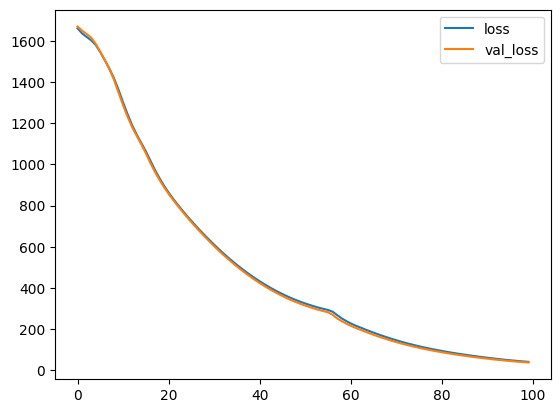

In [15]:
# Plot the training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [16]:
from tensorflow.keras.models import load_model

# Load the best model
model = load_model('model/')

# Evaluate the model
model.evaluate(test_stocks, test_labels)

# Predict the test data
y_pred = model.predict(test_stocks)

10/10 [==============================] - 1s 3ms/step


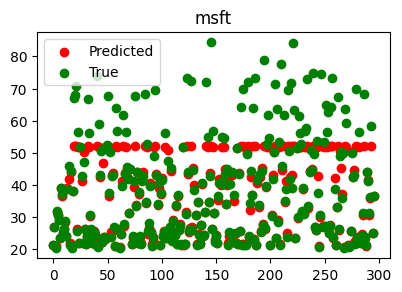

In [23]:
def denormalize(data, mean, std):
    return data * std + mean

# Plot the prediction
plt.figure(figsize=(10, 10))
for i in range(len(stocks_names)):
    plt.subplot(3, 2, i+1)

    #y_test_denorm = denormalize(y_test, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])
    #y_pred_denorm = denormalize(y_pred, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])

    plt.scatter(range(len(y_pred)), y_pred[:, i], label='Predicted', c='r')
    plt.scatter(range(len(test_labels)), test_labels[:, i], label='True', c='g')

    plt.title(stocks_names[i])
    plt.legend()
plt.show()

44/44 [==============================] - 0s 2ms/step


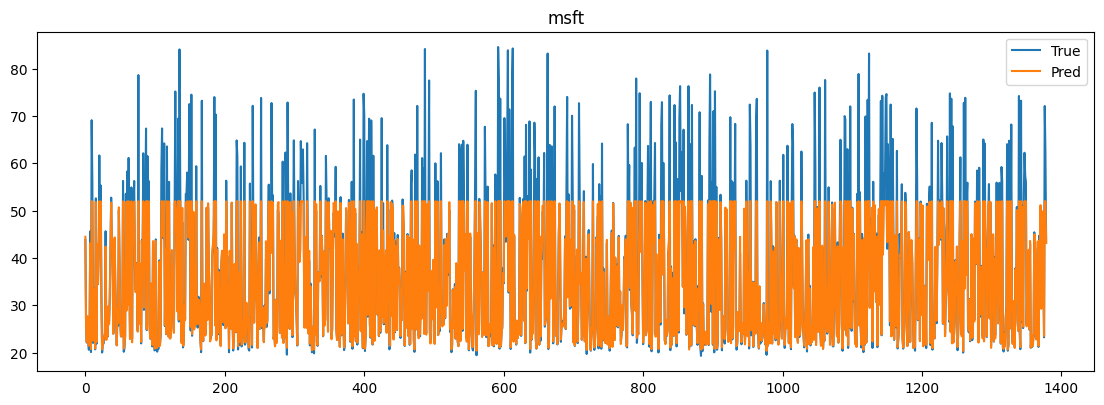

In [18]:
# Plot the prediction on training data
y_pred_train = model.predict(train_stocks)

plt.figure(figsize=(30, 15))
for i in range(len(stocks_names)):
    plt.subplot(3, 2, i+1)

    #y_train_denorm = denormalize(y_train, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])
    #y_pred_train_denorm = denormalize(y_pred_train, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])

    plt.plot(train_labels[:, i], label='True')
    plt.plot(y_pred_train[:, i], label='Pred')
    plt.title(stocks_names[i])
    plt.legend()
plt.show()

10/10 [==============================] - 0s 3ms/step


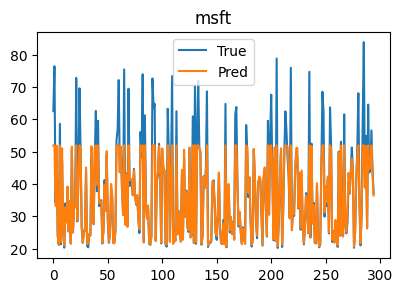

In [19]:
# Plot the prediction on validation data
y_pred_val = model.predict(val_stocks)

plt.figure(figsize=(10, 10))
for i in range(len(stocks_names)):
    plt.subplot(3, 2, i+1)

    #y_val_denorm = denormalize(y_val, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])
    #y_pred_val_denorm = denormalize(y_pred_val, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])

    plt.plot(val_labels[:, i], label='True')
    plt.plot(y_pred_val[:, i], label='Pred')
    plt.title(stocks_names[i])
    plt.legend()
plt.show()

62/62 [==============================] - 0s 2ms/step


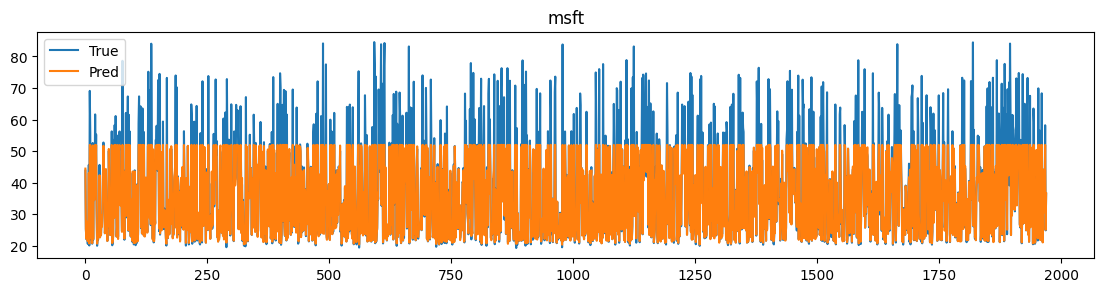

In [20]:
# Plot the prediction for all the data
y_pred_all = model.predict(x)

plt.figure(figsize=(30, 10))
for i in range(len(stocks_names)):
    plt.subplot(3, 2, i+1)

    #y_denorm = denormalize(y, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])
    #y_pred_all_denorm = denormalize(y_pred_all, train_mean[stocks_names[i]]['Close'], train_std[stocks_names[i]]['Close'])

    plt.plot(y[:, i], label='True')
    plt.plot(y_pred_all[:, i], label='Pred')
    plt.title(stocks_names[i])
    plt.legend()
plt.show()